This notebook covers the following topics:
- Hugging Face Transformers
- Introduction to retrieval-augmented generation (RAG)
- ChromaDB

For this demo, the data source will be the [Operating Systems: Three Easy Pieces](https://pages.cs.wisc.edu/~remzi/OSTEP/) textbook. Most chapters fall into one of three sections: virtualization, concurrency, and persistence. There are introductory chapters, "dialogue" and "summary" chapters (usually at the beginning and end of each section), chapters on security, and appendices; to simplify things, we will not consider these chapters.

In [1]:
import os
import shutil
from pathlib import Path
import io
import requests
from bs4 import BeautifulSoup
import pymupdf
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from PIL import Image
import chromadb

DATA_DIR = Path('data')
PDF_DIR = DATA_DIR / 'pdf'
TXT_DIR = DATA_DIR / 'txt'
PRETRAINED_MODEL = 'sentence-transformers/all-MiniLM-L6-v2'

The first part of this notebook (everything up to the Hugging Face section) is just data setup. You don't need to understand the code in detail. After running it, you should end up with a `data` folder with the following directory structure:

    data
    ├── pdf
    │   ├── cpu-api.pdf
    │   └── ...
    └── txt
        ├── cpu-api
        │   ├── 0.txt
        │   └── ...
        └── ...

- `pdf` contains all PDFs from the OSTEP website, one for each chapter.
- `txt` contains a folder for each chapter named identically to the PDF. Each folder contains .txt files, numbered starting from 0, and one for each page.

In [2]:
# Download book to data/pdf
# The following Python code is equivalent to the following Bash command:
# mkdir -p data/pdf && wget -q -r -l1 -A.pdf -nd -P data/pdf https://pages.cs.wisc.edu/~remzi/OSTEP/
os.makedirs(PDF_DIR, exist_ok=True)
url = "https://pages.cs.wisc.edu/~remzi/OSTEP/"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
for link in soup.find_all('a', href=True):
    if link['href'].endswith('.pdf'):
        r = requests.get(url + link['href'])
        with open(os.path.join(PDF_DIR, link['href']), 'wb') as f:
            f.write(r.content)

In [3]:
# Create data/txt
if os.path.exists(TXT_DIR):
    shutil.rmtree(TXT_DIR)
for chapter_pdf_file in PDF_DIR.iterdir():
    name, ext = os.path.splitext(chapter_pdf_file.name)
    if ext != '.pdf':
        continue
    chapter_txt_folder = TXT_DIR / name
    os.makedirs(chapter_txt_folder)
    doc = pymupdf.open(chapter_pdf_file)
    for page_num, page in enumerate(doc):
        with open(chapter_txt_folder / f'{page_num}.txt', 'w') as f:
            f.write(page.get_text())

After inspecting the data, we can draw the following conclusions:
- PDF filenames containing "dialogue" are either a dialogue or summary chapter.
- Filenames starting with "cpu" or "vm" are in the virtualization section (exception: `vmm-intro.pdf` is in the appendix).
- Filenames starting with "threads" are in the concurrency section (exception: `threads-monitors.pdf` is in the appendix).
- Filenames starting with "file" or "threads" are in the persistence section.
- For all the chapters we care about, `0.txt` begins with the chapter number on its own line.

In [4]:
# Read page-level data from relevant chapters
ids = []       # Page ID: '{chapter_id}_{page_num}'
contents = []  # Text content on page
labels = []    # What section page falls under

relevant_chapters = []
for chapter_txt_folder in TXT_DIR.iterdir():
    chapter_id = chapter_txt_folder.name
    if 'dialogue' in chapter_id or chapter_id in ['vmm-intro', 'threads-monitors']:
        continue
    if chapter_id.startswith(('cpu', 'vm')):
        section_name = 'virtualization'
    elif chapter_id.startswith('threads'):
        section_name = 'concurrency'
    elif chapter_id.startswith(('file', 'dist')):
        section_name = 'persistence'
    else:
        continue

    # Sanity check that the chapters we pulled are from the correct section
    with open(chapter_txt_folder / '0.txt', 'r') as f:
        chapter_number = int(f.readline())
    if section_name == 'virtualization':
        assert 4 <= chapter_number <= 23
    elif section_name == 'concurrency':
        assert 26 <= chapter_number <= 33
    else:  # section_name == 'persistence'
        assert 36 <= chapter_number <= 50
    
    for page_txt_file in chapter_txt_folder.iterdir():
        page_num = os.path.splitext(page_txt_file.name)[0]
        with open(page_txt_file, 'r') as f:
            content = f.read()
        ids.append(f'{chapter_id}_{page_num}')
        contents.append(content)
        labels.append(section_name)

ids[:5], contents[:5], labels[:5]

(['threads-cv_15',
  'threads-cv_14',
  'threads-cv_16',
  'threads-cv_17',
  'threads-cv_13'],
 ['16\nCONDITION VARIABLES\nthe cost, as we’ve discussed, is that too many threads might be woken.\nThe astute reader might also have noticed we could have used this ap-\nproach earlier (see the producer/consumer problem with only a single\ncondition variable). However, in that case, a better solution was avail-\nable to us, and thus we used it. In general, if you ﬁnd that your program\nonly works when you change your signals to broadcasts (but you don’t\nthink it should need to), you probably have a bug; ﬁx it! But in cases like\nthe memory allocator above, broadcast may be the most straightforward\nsolution available.\n30.4 Summary\nWe have seen the introduction of another important synchronization\nprimitive beyond locks: condition variables. By allowing threads to sleep\nwhen some program state is not as desired, CVs enable us to neatly solve\na number of important synchronization proble

## Hugging Face Transformers
[Hugging Face Transformers](https://huggingface.co/docs/transformers/en/index) is a library with pre-trained models that you can easily download, then finetune for your specific application, or even make predictions out of the box. In this demo, we will download a [Sentence Transformers](https://huggingface.co/sentence-transformers) model (specifically `all-MiniLM-L6-v2`), and use it to compute embedding vectors for each page in the textbook. These embeddings encode the meaning of a text passage into a fixed-size vector, and can be used for clustering, semantic search, and more.

The following example is adapted from the [`all-MiniLM-L6-v2` page](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2). We will go through it line by line; even though this level of detail isn't necessary to understand how to use Sentence Transformers to compute embeddings, the principles apply to most if not all transformer models on Hugging Face.

In [5]:
def mean_pooling(token_embeddings, attention_mask):
    """Mean pooling over token embeddings.

    Args:
        token_embeddings: Tensor with shape `(batch_size, seq_len, hidden_dim)`.
        attention_mask: Tensor whape `(batch_size, seq_len)`.

    Returns:
        Tensor with shape `(batch_size, hidden_dim)`.
    """
    input_mask_expanded = attention_mask.unsqueeze(-1).float()  # (batch_size, seq_len, 1)
    return (
        torch.sum(token_embeddings * input_mask_expanded, 1)    # (batch_size, hidden_dim)
        / torch.clamp(input_mask_expanded.sum(1), min=1e-9)     # (batch_size, 1)
    )

sentences = [
    "Hello world!",
    "This is an example sentence.",
    "When my code doesn't compile, I feel unhappiness."
]

tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
model = AutoModel.from_pretrained(PRETRAINED_MODEL)

# Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
encoded_input

{'input_ids': tensor([[  101,  7592,  2088,   999,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  2023,  2003,  2019,  2742,  6251,  1012,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  2043,  2026,  3642,  2987,  1005,  1056,  4012, 22090,  1010,
          1045,  2514,  4895,  3270,  9397,  9961,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

The tokenizer outputs `encoded_input`, which is used directly by the model as input. Each tensor in `encoded_input` has shape `(n_sentences, seq_len)`. To get a better understanding of `encoded_input`, for each of the example sentences, we will print it along with its token sequence, `input_ids`, and `attention_mask`:

In [6]:
for sentence, input_ids, attention_mask in zip(sentences, encoded_input.input_ids, encoded_input.attention_mask):
    print(sentence)
    print(tokenizer.convert_ids_to_tokens(input_ids))
    print(input_ids.tolist())
    print(attention_mask.tolist(), '\n')

Hello world!
['[CLS]', 'hello', 'world', '!', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[101, 7592, 2088, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 

This is an example sentence.
['[CLS]', 'this', 'is', 'an', 'example', 'sentence', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[101, 2023, 2003, 2019, 2742, 6251, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 

When my code doesn't compile, I feel unhappiness.
['[CLS]', 'when', 'my', 'code', 'doesn', "'", 't', 'com', '##pile', ',', 'i', 'feel', 'un', '##ha', '##pp', '##iness', '.', '[SEP]']
[101, 2043, 2026, 3642, 2987, 1005, 1056, 4012, 22090, 1010, 1045, 2514, 4895, 3270, 9397, 9961, 1012, 102]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 



- `tokenizer.convert_ids_to_tokens()` returns a token sequence.
    - The tokens in square brackets are special tokens.
        - `[CLS]` stands for "classification" and is typically used by classification models.
        - `[SEP]` stands for "separator" and is used to separate different segments in the input. For single sentence tasks such as this, it marks the end of the sentence. For sentence pair tasks such as question answering, it marks the end of each sentence.
        - `[PAD]` is used to pad all sequences to the same length, as they are fed as a batch to PyTorch.
    - Notice that punctuation get their own token, and long words can be broken up into multiple tokens (e.g., "unhappiness" becomes `['un', '##ha', '##pp', '##iness']`).
- `input_ids` are integer IDs representing the tokens. These IDs are directly consumed by the model.
- `attention_mask` is a binary tensor where `[PAD]` tokens are 0, all other tokens are 1.
- `token_type_ids` are irrelevant for this model, but are typically used in sentence-pair tasks.

In [7]:
# Compute model output
with torch.no_grad():
    model_output = model(**encoded_input)
model_output

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.1611,  0.0383,  0.0337,  ..., -0.3031, -0.1258,  0.0034],
         [-0.4000,  0.2809,  0.3544,  ...,  0.6810,  0.3037,  0.7509],
         [-0.1470,  0.2671, -0.3663,  ..., -0.7188, -0.1713,  0.1648],
         ...,
         [-0.1205, -0.0790,  0.5692,  ...,  0.0872,  0.2775, -0.1787],
         [-0.1270, -0.0987,  0.5793,  ...,  0.0958,  0.2742, -0.2094],
         [-0.1359, -0.1212,  0.5702,  ...,  0.0717,  0.2094, -0.2754]],

        [[ 0.0376, -0.0152,  0.1799,  ...,  0.0785, -0.1766, -0.2721],
         [ 0.8159,  0.7382,  0.2699,  ...,  0.4285,  0.6515,  0.5702],
         [ 0.0259, -0.0277,  0.1088,  ...,  0.3457,  0.8813, -0.0232],
         ...,
         [-0.0445,  0.1233,  0.4717,  ...,  0.3068,  0.1893, -0.2549],
         [-0.0307,  0.1198,  0.6014,  ...,  0.3521,  0.3159, -0.3466],
         [-0.0094,  0.0964,  0.5927,  ...,  0.3371,  0.2708, -0.4414]],

        [[ 0.0131,  0.2326, -0.0064,  ...,  0.0584, -

`pooler_output` is irrelevant for this model, but it is a representation of the `[CLS]` token used by classification models. `last_hidden_state` contains token embeddings and has shape `(n_sentences, seq_len, hidden_dim)`; for each sentence, each token (including special tokens) is mapped to a vector of length `hidden_dim = 384` by the model. For our purposes, we obtain sentence embeddings by pooling the token embeddings, however outside of this context, these token embeddings can also be used for token classification tasks such as named entity recognition.

In [8]:
model_output.last_hidden_state.size()

torch.Size([3, 18, 384])

Finally, token embeddings are pooled, meaning that for each sentence, we take the average over non-pad token embeddings; we use the attention mask to ensure we do not include pad tokens. Then, we L2 normalize the resulting embeddings.

In [9]:
embeddings = mean_pooling(model_output.last_hidden_state, encoded_input.attention_mask)
embeddings = F.normalize(embeddings, p=2, dim=1)
embeddings.size()

torch.Size([3, 384])

## Retrieval-augmented generation (RAG)
RAG is a method where LLMs generate repsonses using supporting documents. Given a query, a RAG system first searches a database for the most relevant documents; then, both the query and documents are given to an LLM to produce an answer.

We will implement retrieval using Sentence Transformer embeddings. To show how this works, we will implement vector search using just PyTorch; later, we will show how to use ChromaDB, which abstracts away a lot of the details and more scalable.

In [10]:
class VectorDatabase:
    """Vector database built around Hugging Face Transformers.

    Documents and queries are embedded by computing token embeddings, then applying mean pooling.
    Nearest neighbors are retrieved using cosine similarity.

    Attributes:
        tokenizer: Hugging Face tokenizer.
        model: Hugging Face model that produces token embeddings.
        max_length: Maximum sequence length. If None, model's maximum length is used.
        ids: Document IDs stored in database.
        embeddings: Document vectors stored in database.
    """
    def __init__(self, pretrained_model=PRETRAINED_MODEL, max_length=None):
        """
        Args:
            pretrained_model: Hugging Face model.
            max_length: Maximum sequence length. If None, model's maximum length is used.
        """
        self.tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
        self.model = AutoModel.from_pretrained(pretrained_model)
        self.max_length = max_length
        self.ids = []
        self.embeddings = torch.tensor([])
    
    def _compute_embeddings(self, text):
        """
        Args:
            text: Single string or list of strings.

        Returns:
            Tensor with shape `(n_texts, hidden_dim)`.
        """
        encoded_input = self.tokenizer(
            text,
            truncation=True, max_length=self.max_length,  # Truncate to max_length
            padding=True, return_tensors='pt'  # Return padded tensors
        )
        with torch.no_grad():
            model_output = self.model(**encoded_input)
        embeddings = mean_pooling(model_output.last_hidden_state, encoded_input.attention_mask)
        embeddings = F.normalize(embeddings, p=2, dim=1)
        return embeddings
    
    def add(self, ids, documents):
        """Add document(s) to database.

        Args:
            ids: Single ID or list of IDs.
            documents: Single string or list of strings.
        """
        self.ids.extend(ids)
        self.embeddings = torch.cat((self.embeddings, self._compute_embeddings(documents)))
    
    def query(self, query_texts, n_results=5):
        """Query for k nearest neighbors in database.

        Args:
            query_texts: Single string or list of strings.
            n_results: Number of nearest neighbors.

        Returns:
            Dictionary with the following structure:
            {
                'ids': list[list[Any]],      # Shape (n_queries, n_results)
                'scores': list[list[float]]  # Cosine similarity, shape (n_queries, n_results)
            }
        """
        query_embeddings = self._compute_embeddings(query_texts)  # (n_queries, hidden_dim)
        scores = torch.matmul(
            query_embeddings,   # (n_queries, hidden_dim)
            self.embeddings.T   # (hidden_dim, n_documents)
        )                       # Result: (n_queries, n_documents)
        topk_result = torch.topk(scores, k=min(n_results, scores.size(1)))
        return {
            'ids': np.array(self.ids)[topk_result.indices].tolist(),
            'scores': topk_result.values.tolist()
        }

db = VectorDatabase()
db.add(ids, contents)

We hypothesize that embeddings belonging to the same section (virtualization, concurrency, and persistence) should be similar. To check that this is indeed the case, we apply dimensionality reduction using t-SNE, and visualize the embeddings in 2D.

(<Figure size 1000x800 with 1 Axes>,
 <Axes: title={'center': 'Embeddings after applying t-SNE'}>)

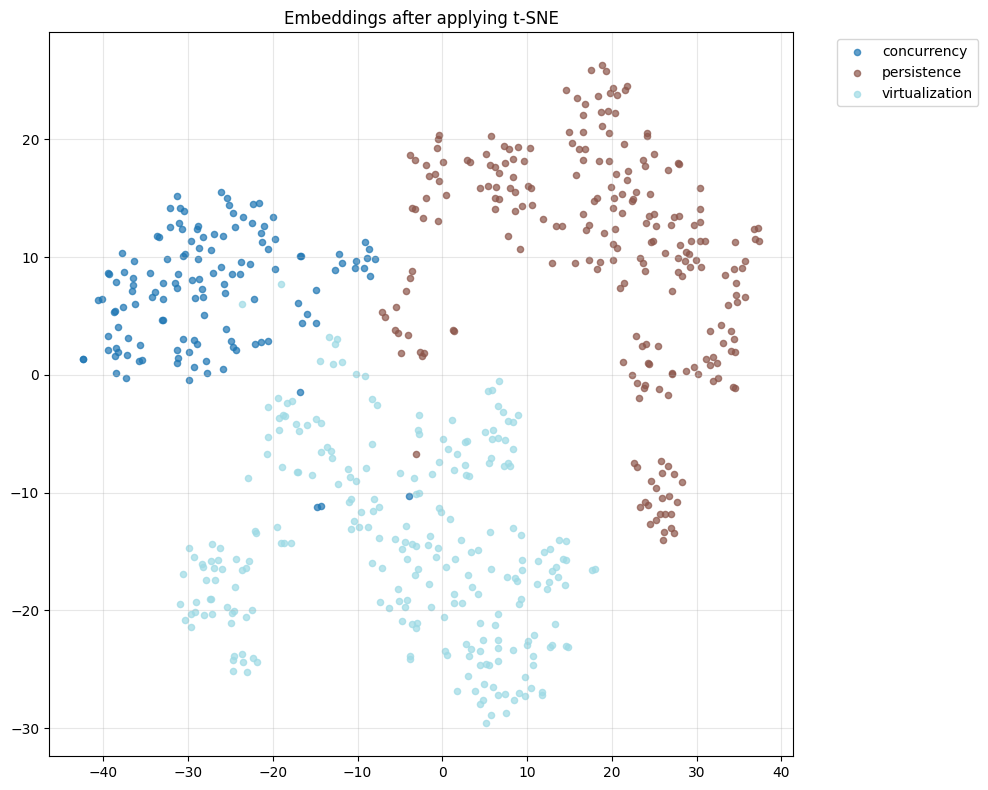

In [11]:
def visualize_embeddings(X, y, **kwargs):
    """Visualize embeddings in 2D using t-SNE for dimensionality reduction.

    Args:
        X: Array with shape `(n_samples, n_features)` containing high-dimensional embeddings.
        y: Array with shape `(n_samples,)` containing labels.
        kwargs: Optional `sklearn.manifold.TSNE` arguments (excluding `n_components`).

    Returns:
        Tuple `(fig, ax)` with Matplotlib `Figure` and `Axes` objects.
    """
    y = np.asarray(y)
    X_transformed = TSNE(n_components=2, **kwargs).fit_transform(X)
    fig, ax = plt.subplots(figsize=(10, 8))
    unique_labels = np.unique(y)
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))
    for i, label in enumerate(unique_labels):
        mask = y == label
        ax.scatter(
            X_transformed[mask, 0], X_transformed[mask, 1],
            label=label, color=colors[i],
            alpha=0.7, s=20
        )
    ax.set_title('Embeddings after applying t-SNE')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig, ax

visualize_embeddings(db.embeddings, labels)

Now let's see how well this works at retrieving the right pages from the book.

In [12]:
questions = [
    "Is there a name for a scheduler that runs one process for some fixed amount of time, then switches to the next job, and continues until all jobs are done?",
    "What is the difference between internal and external fragmentation?"
]
result = db.query(questions, 5)
result

{'ids': [['cpu-sched_6',
   'cpu-sched_10',
   'cpu-sched-multi_6',
   'cpu-sched-mlfq_4',
   'cpu-sched-mlfq_0'],
  ['file-ffs_1',
   'vm-segmentation_8',
   'vm-freespace_2',
   'vm-freespace_9',
   'vm-freespace_1']],
 'scores': [[0.54289311170578,
   0.5055575966835022,
   0.5021352767944336,
   0.4928138256072998,
   0.4740619659423828],
  [0.4063163697719574,
   0.40546658635139465,
   0.4026739299297333,
   0.3861624598503113,
   0.37650853395462036]]}

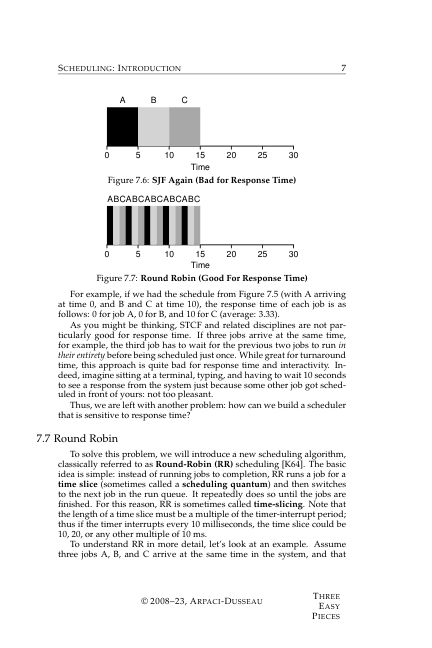

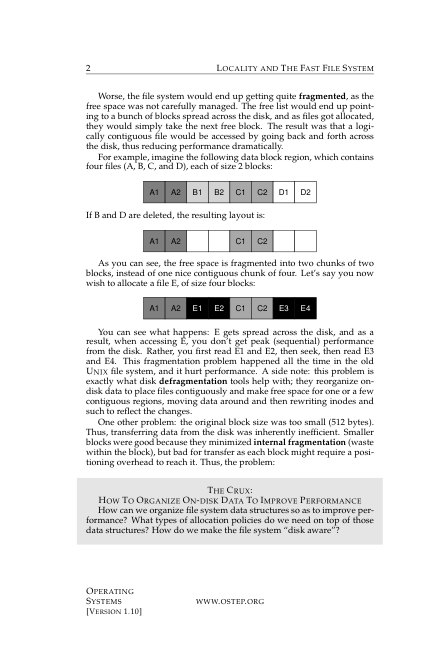

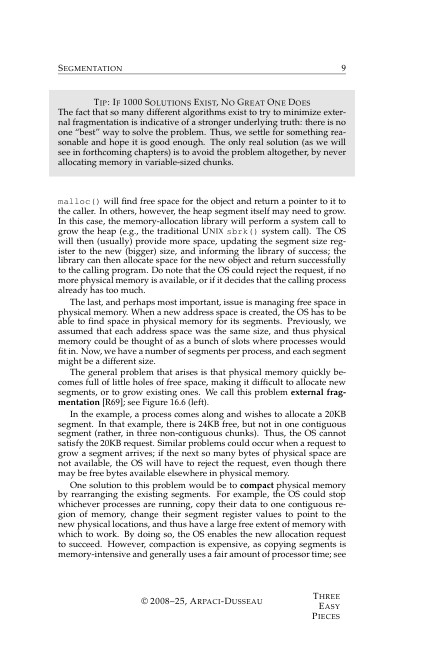

In [13]:
def display_page(pdf_file, page_idx):
    doc = pymupdf.open(pdf_file)
    page = doc.load_page(page_idx)
    pix = page.get_pixmap()
    img_bytes = pix.tobytes()
    img = Image.open(io.BytesIO(img_bytes))
    display(img)

display_page(PDF_DIR / 'cpu-sched.pdf', 6)
display_page(PDF_DIR / 'file-ffs.pdf', 1)
display_page(PDF_DIR / 'vm-segmentation.pdf', 8)

## ChromaDB
Our implementation of a vector database is useful for learning, but a more practical option is [ChromaDB](https://www.trychroma.com/home).

In [14]:
client = chromadb.PersistentClient()
collection = client.get_or_create_collection('ostep')
collection.add(ids=ids, documents=contents)

# How to get document embeddings from Chroma
collection.get(include=['embeddings'])

{'ids': ['threads-cv_15',
  'threads-cv_14',
  'threads-cv_16',
  'threads-cv_17',
  'threads-cv_13',
  'threads-cv_12',
  'threads-cv_10',
  'threads-cv_11',
  'threads-cv_9',
  'threads-cv_8',
  'threads-cv_5',
  'threads-cv_4',
  'threads-cv_6',
  'threads-cv_7',
  'threads-cv_3',
  'threads-cv_2',
  'threads-cv_0',
  'threads-cv_1',
  'threads-cv_18',
  'file-implementation_15',
  'file-implementation_14',
  'file-implementation_16',
  'file-implementation_17',
  'file-implementation_13',
  'file-implementation_12',
  'file-implementation_10',
  'file-implementation_11',
  'file-implementation_9',
  'file-implementation_8',
  'file-implementation_5',
  'file-implementation_4',
  'file-implementation_6',
  'file-implementation_7',
  'file-implementation_3',
  'file-implementation_2',
  'file-implementation_0',
  'file-implementation_1',
  'threads-api_10',
  'threads-api_11',
  'threads-api_9',
  'threads-api_8',
  'threads-api_5',
  'threads-api_4',
  'threads-api_6',
  'threads-ap

In [15]:
chroma_result = collection.query(query_texts=questions, n_results=5)
chroma_result

{'ids': [['cpu-sched-multi_6',
   'cpu-sched_10',
   'cpu-sched_5',
   'cpu-sched-mlfq_0',
   'cpu-sched_4'],
  ['vm-freespace_2',
   'file-ffs_1',
   'vm-segmentation_1',
   'vm-freespace_9',
   'vm-segmentation_8']],
 'embeddings': None,
 'documents': [['MULTIPROCESSOR SCHEDULING (ADVANCED)\n7\nto run on the same CPU if possible. Speciﬁcally, one might provide afﬁn-\nity for some jobs, but move others around to balance load. For example,\nimagine the same ﬁve jobs scheduled as follows:\nCPU 3\nCPU 2\nCPU 1\nCPU 0\nD\nD\nD\nD\nE\nC\nC\nC\nE\nC\nB\nB\nE\nB\nB\nA\nE\nA\nA\nA\n ... (repeat) ...\n ... (repeat) ...\n ... (repeat) ...\n ... (repeat) ...\nIn this arrangement, jobs A through D are not moved across proces-\nsors, with only job E migrating from CPU to CPU, thus preserving afﬁn-\nity for most. You could then decide to migrate a different job the next\ntime through, thus achieving some kind of afﬁnity fairness as well. Im-\nplementing such a scheme, however, can be complex.\nThus

By default, Chroma uses the same Sentence Transformer model (`all-MiniLM-L6-v2`) to embed documents, so we can sanity check Chroma's results against ours. Specifically, we can check that we get the same document embeddings, the same top results, and the same scores/distances for those top results.

Two things to keep in mind:
- By default, Chroma uses a maximum sequence length of 256. So to do an apples-to-apples comparison, we have to use the same `max_length`.
- We used cosine similarity, equivalently the dot product since vectors are normalized. By default, Chroma uses the squared L2 norm, which has the following relationship with the dot product when vectors are normalized:
$$\|x - y\|^2 = 2(1 - x\cdot y).$$

In [16]:
# Create our vector database with max_length=256
db = VectorDatabase(max_length=256)
db.add(ids, contents)
our_result = db.query(query_texts=questions, n_results=5)

# Check that our document embeddings match
assert np.isclose(
    db.embeddings.numpy(),
    collection.get(include=['embeddings'])['embeddings'],
    rtol=0, atol=1e-6
).all()

# Check that our top 5 documents match
assert our_result['ids'] == chroma_result['ids']

# Check that our scores match
assert np.isclose(
    2*(1 - np.array(our_result['scores'])),
    np.array(chroma_result['distances'])
).all()

## Summary
We went over the basics of using Hugging Face for inference, including an overview of the tokenizer and its outputs, the process of feeding tokenized input into the model to get token embeddings, and computing sentence embeddings from these token embeddings. We also saw how to visualize these embeddings using t-SNE. Finally, we introduced RAG and implemented a vector database for document retrieval. In `gemini_rag_pipeline_demo.ipynb`, we will continue this RAG example, and show how to generate responses supported by the retrieved documents.